In [1]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

True
13.0
NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [ ]:
from pathlib import Path
import pandas as pd 

df = pd.read_csv('data/metadata.csv')
df.rename(columns={'Folder': 'video_id'}, inplace=True)
# df['video_id'] = df['File Path'].apply(lambda x: Path(x).stem)
df.head()
# df.to_csv('data/metadata.csv', index=False)

In [2]:
import os
import pandas as pd
from pathlib import Path

def create_metadata_from_folders(folder_path: str, output_csv: str = 'data/metadata2.csv') -> pd.DataFrame:
    """
    Create a metadata CSV with video_id and label columns based on folder names.
    
    Args:
        folder_path: Path to the parent folder containing subfolders
        output_csv: Path where the CSV file will be saved
    
    Returns:
        DataFrame with video_id and label columns
    """
    folder_path = Path(folder_path)
    
    # Get all direct children folders
    subfolders = [f for f in folder_path.iterdir() if f.is_dir()]
    
    # Create list to store data
    data = []
    
    for folder in subfolders:
        folder_name = folder.name
        # Label is 1 if folder name contains '_', otherwise 0
        label = 1 if '_' in folder_name else 0
        data.append({'video_id': folder_name, 'label': label})
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Save to CSV
    df.to_csv(output_csv, index=False)
    print(f"Created {output_csv} with {len(df)} entries")
    
    return df


create_metadata_from_folders('data/images_successive', 'data/metadata2.csv')

Created data/metadata2.csv with 2000 entries


,video_id,label
0,000,0
1,000_003,1
2,001,0
3,001_870,1
4,002,0
...,...,...
1995,997_040,1
1996,998,0
1997,998_561,1
1998,999,0


In [2]:
import os
import cv2
import pandas as pd
from pathlib import Path
from huggingface_hub import hf_hub_download
from ultralytics import YOLO
from supervision import Detections

def load_model_and_metadata(videos_root: str, metadata_csv: str) -> tuple[YOLO, pd.DataFrame]:
    """Load the YOLO model and metadata, ensuring video paths are relative."""
    model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")
    model = YOLO(model_path)
    metadata = pd.read_csv(metadata_csv)
    metadata['video_path'] = metadata['video_path'].apply(lambda p: str(Path(p).relative_to(videos_root)))
    return model, metadata

def process_video(
    video_path: Path,
    model: YOLO,
    images_root: str,
    annotations_root: str,
    metadata: pd.DataFrame,
    videos_root: str,
    frames_per_second: int,
) -> None:
    """Process a single video: extract faces, save crops and annotations with labels."""
    rel_path = video_path.relative_to(videos_root)
    video_stem = video_path.stem
    rel_dir = rel_path.parent

    # Create output directories
    output_images_dir = Path(images_root) / rel_dir / video_stem
    output_annotations_dir = Path(annotations_root) / rel_dir / video_stem
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_annotations_dir, exist_ok=True)

    # Get label for this video
    label = metadata[metadata['video_path'] == str(rel_path)]['label'].values[0]

    cap = cv2.VideoCapture(str(video_path))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps // frames_per_second) if frames_per_second > 0 else 1
    frame_id = 0
    saved_frame_id = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_id % frame_interval == 0:
            results = model(frame)
            detections = Detections.from_ultralytics(results[0])
            for i, box in enumerate(detections.xyxy):
                x1, y1, x2, y2 = map(int, box)
                face_crop = frame[y1:y2, x1:x2]
                img_name = f"frame_{saved_frame_id}_face_{i}.jpg"
                img_path = output_images_dir / img_name
                cv2.imwrite(str(img_path), face_crop)

                img_height, img_width = face_crop.shape[:2]
                x_center = (x1 + x2) / 2 / img_width
                y_center = (y1 + y2) / 2 / img_height
                width = (x2 - x1) / img_width
                height = (y2 - y1) / img_height
                annotation_line = f"{label} {x_center} {y_center} {width} {height}\n"
                annotation_path = output_annotations_dir / f"frame_{saved_frame_id}_face_{i}.txt"
                with open(annotation_path, "w") as f:
                    f.write(annotation_line)
            saved_frame_id += 1
        frame_id += 1
    cap.release()

def extract_faces_from_videos(
    videos_root: str,
    images_root: str,
    annotations_root: str,
    metadata_csv: str,
    frames_per_second: int = 1,
) -> None:
    """
    Main function: Extracts faces from all .mp4 files in videos_root,
    saves face crops and YOLO annotations in parallel structure,
    and uses metadata.csv for labeling.
    """
    model, metadata = load_model_and_metadata(videos_root, metadata_csv)
    for video_path in Path(videos_root).rglob("*.mp4"):
        process_video(video_path, model, images_root, annotations_root, metadata, videos_root, frames_per_second)
    print(f"Face extraction and annotation completed for {frames_per_second} frames per second!")


c:\Users\lorra\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



0: 384x640 3 FACEs, 10.0ms
Speed: 2.3ms preprocess, 10.0ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)
Detections on the first frame:


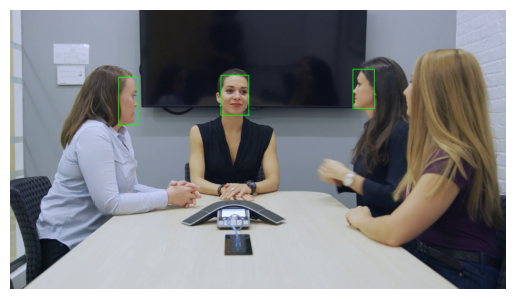

In [5]:
import matplotlib.pyplot as plt

def print_detections_on_first_frame(video_path: Path, model: YOLO) -> None:
    """Print all detections on the first frame of a video."""
    cap = cv2.VideoCapture(str(video_path))
    ret, frame = cap.read()
    if not ret:
        print("Failed to read the video.")
        return
    results = model(frame)
    detections = Detections.from_ultralytics(results[0])
    print("Detections on the first frame:")
    for i, box in enumerate(detections.xyxy):
        x1, y1, x2, y2 = map(int, box[:4])
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # Show the frame with all boxes drawn
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    cap.release()


# Example usage:
video_path = Path("data/videos/DeepFakeDetection/01_02__meeting_serious__YVGY8LOK.mp4")

model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")
model = YOLO(model_path)

print_detections_on_first_frame(video_path, model)

In [10]:
# # Example usage:
# extract_faces_from_videos(
#     input_folder="data/videos/tests",
#     output_images_dir="data/images/test",
#     output_annotations_dir="data/annotations/test",
#     frames_per_second=2,  # Extract 2 frames per second
# )

extract_faces_from_videos(
    videos_root="data/videos/tests",
    images_root="data/images/tests",
    annotations_root="data/annotations/tests",
    metadata_csv="data/metadata.csv",
    frames_per_second=2,
)



0: 384x640 1 FACE, 72.0ms
Speed: 8.3ms preprocess, 72.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 FACE, 65.5ms
Speed: 1.7ms preprocess, 65.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 FACE, 55.8ms
Speed: 1.3ms preprocess, 55.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 FACE, 58.2ms
Speed: 2.2ms preprocess, 58.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 FACE, 60.8ms
Speed: 1.6ms preprocess, 60.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 FACE, 59.3ms
Speed: 1.6ms preprocess, 59.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 FACE, 59.8ms
Speed: 2.2ms preprocess, 59.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 FACE, 71.2ms
Speed: 1.4ms preprocess, 71.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x